# Easy explain CAM for Image models in details

The CAMEexplain class supports both SmoothGradCAMpp & LayerCAM explainers.

SmoothGradCAMpp and LayerCAM are both techniques for generating visual explanations for the decisions of convolutional neural networks (CNNs), but they differ in their approach and focus.

## SmoothGradCAMpp

SmoothGradCAMpp is an extension of Grad-CAM++ (Gradient-weighted Class Activation Mapping) and integrates ideas from SmoothGrad. Grad-CAM++ itself is an improvement over Grad-CAM, designed to provide finer-grained visual explanations of CNN decisions.

The core idea of Grad-CAM++ (and by extension, SmoothGradCAMpp) is to use the gradients flowing into the final convolutional layer of the CNN to produce a heatmap that highlights the important regions in the input image for predicting the concept. SmoothGradCAMpp enhances this by averaging the maps obtained from multiple noisy versions of the input image, aiming to reduce noise and highlight salient features more effectively.

SmoothGradCAMpp is particularly useful for getting more detailed and less noisy heatmaps that indicate why a particular decision was made by the model. It's beneficial for understanding model behavior on a specific instance.

## LayerCAM

LayerCAM is a relatively newer technique that also aims to provide visual explanations for model decisions. Unlike Grad-CAM and its variants, LayerCAM can generate more detailed heatmaps by integrating features from multiple layers of the CNN.

LayerCAM modifies the way of aggregating feature maps from different layers. It emphasizes the importance of each pixel by considering its influence across multiple layers, not just the final convolutional layer. This approach allows LayerCAM to highlight finer details and more relevant areas in the input image for the model's decision.

LayerCAM is particularly useful when you want to capture the model's attention at multiple levels of abstraction, from lower-level features to higher-level semantics. It can provide a more comprehensive view of how different layers contribute to the final decision, making it valuable for in-depth analysis of model behavior.

## Key differences

Layer Focus: SmoothGradCAMpp focuses on the final convolutional layer and uses noise reduction techniques to enhance clarity. LayerCAM aggregates information across multiple layers for a more detailed heatmap.

Detail and Scope: LayerCAM can potentially provide more detailed insights by leveraging multiple layers, while SmoothGradCAMpp seeks to refine the clarity of heatmaps derived from a single layer.

Noise Reduction: The integration of SmoothGrad into GradCAMpp (forming SmoothGradCAMpp) specifically aims to reduce noise in the generated heatmaps, a feature not explicitly designed into LayerCAM.

Implementation Complexity: SmoothGradCAMpp's methodology of adding noise and averaging might be more straightforward to implement as an extension of existing Grad-CAM++ techniques, while LayerCAM requires a more complex aggregation of features across layers.

Both methods offer valuable insights into model decisions, and the choice between them depends on the specific requirements of the explanation task, such as the need for detail, clarity, or understanding multi-layer contributions.

## Grad-CAM


Grad-CAM, or Gradient-weighted Class Activation Mapping, introduced in this [paper](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/1610.02391.pdf), is a prominent algorithm in Explainable AI (XAI). It was specifically developed for evaluation with pretrained networks like Resnet50 and VGG19. Grad-CAM enables us to identify the parts of an image that influenced the model's labeling decision.

This feature is particularly useful for analyzing instances where the model has misclassified an image. The Grad-CAM technique is known for its simplicity and ease of implementation. This notebook offers a guide on how to apply and leverage this algorithm within a PyTorch framework.

Let's begin with the code...

### Import libraries

In [6]:
import warnings 
warnings.filterwarnings('ignore')

import sys
import os

from torchvision.models import resnet50, vgg19
from torchvision.io.image import read_image

# Set up paths
module_path = os.path.abspath(os.path.join("../../"))
if module_path not in sys.path:
    sys.path.append(module_path)

from easy_explain import CAMExplain

### Loading models

Let's load our models. We will use two examples one with a vgg19 and one with resnet50 architecture.

In [7]:
resnet50_model = resnet50(weights="ResNet50_Weights.DEFAULT").eval()
vgg19_model = vgg19(weights="VGG19_Weights.DEFAULT").eval()

### Image and explanation initialisation

Also a transformation parameters dictionary in order to be aligned with the needs of the models.

In [8]:
trans_params = {"ImageNet_transformation":
  {"Resize": {"h": 224,"w": 224},
  "Normalize": {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}}}

Let's get our image. It will be an example image downloaded from [Unsplash](https://unsplash.com/photos/giraffe-surrounded-by-brown-grass-pf97TYdQlWM)

In [9]:
img = read_image("../data/mike-setchell-pf97TYdQlWM-unsplash.jpg")

Creation of the explainer based on the CAMExplain Class for the resnet model

In [10]:
explainer = CAMExplain(model = resnet50_model) 

Basic transformations for the image based on our easy explain class.
Convert the image into the tensor format required by the models.

In [11]:
input_tensor = explainer.transform_image(img, trans_params["ImageNet_transformation"])

### Examination of the model's layers

Let's have a quick look at the layers of the selected model

In [12]:
print(resnet50_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

To determine the specific layers to analyze using Class Activation Mapping (CAM), we need to inspect the model's architecture and select the relevant layers based on our objective, such as identifying which features influence the model's predictions at different levels.

Each model possesses unique layers, necessitating an overview of its structure to make an informed selection. By default, if no target layer is specified, the algorithm applies to the final layer of the model. For a more comprehensive visualization, multiple layer names can be included in a list.

Through this we can deside which layers we want to select and visualise...

### Application of the XAI

Let's visualise for this model some of our preference layers. We will select layers 2, 3 & 4.

INFO:root:The cams per target layer are: [torch.Size([1, 7, 7])]


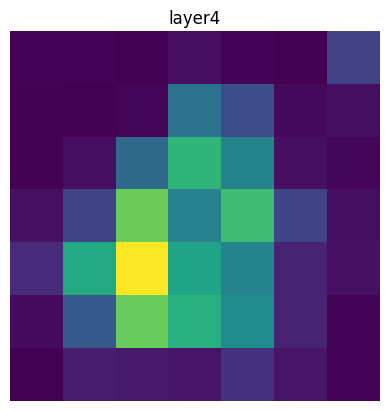

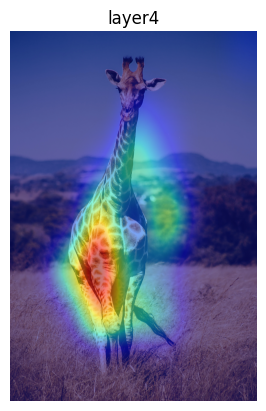

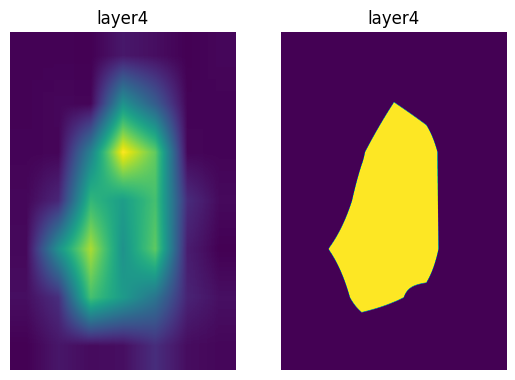

INFO:root:Successfully retrieved CAMs for multiple layers
INFO:root:The cams per target layer are: [torch.Size([1, 28, 28]), torch.Size([1, 14, 14]), torch.Size([1, 7, 7])]


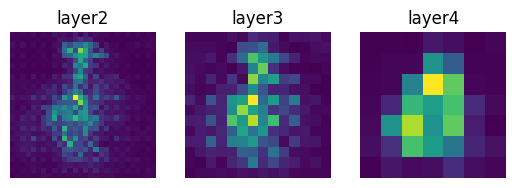

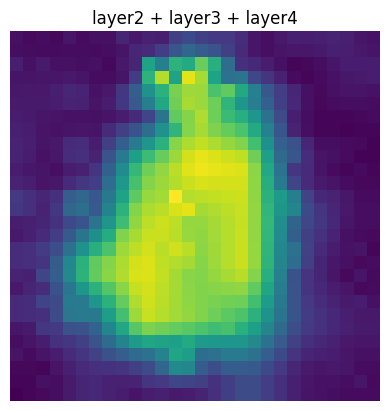

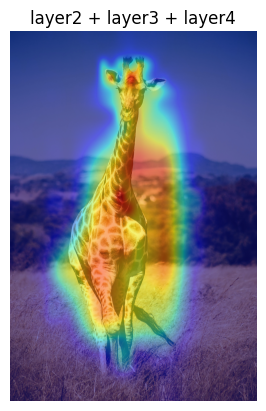

In [13]:
explainer.generate_explanation(img, input_tensor, multiple_layers=["layer2", "layer3", "layer4"])

The impact of each layer on the outcome is distinct, as observed from the different layers. Every layer contributes uniquely to the final decision. Ultimately, we can view an aggregated visualization that combines the effects of all the chosen layers.

Now let's use another model (vgg model). As mentioned, each model features a unique architecture, comprising distinct layers and naming conventions for those layers.

For the ResNet50 model, GradCam was applied to its final layer by default (since None is specified), as well as an aggregated GradCam analysis for layers "layer2", "layer3", and "layer4".
For the VGG19 model, GradCam is executed individually for each layer within the features section in order to also see the possible use of this xai package.

In [14]:
explainer = CAMExplain(model = vgg19_model)

Let's have a look at the architecture...

In [15]:
vgg19_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

It is different than the previous model...

Basic transformations for the image based on our easy explain class


In [16]:
input_tensor = explainer.transform_image(img, trans_params["ImageNet_transformation"])

Let's visualise for this model all the layers with features

Through these visualisations we will be able to undrstand each one of the features that the model gets out of the image behaves in order to contribute to the last result.

INFO:root:The cams per target layer are: [torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 224, 224]), torch.Size([1, 112, 112]), torch.Size([1, 112, 112]), torch.Size([1, 112, 112]), torch.Size([1, 112, 112]), torch.Size([1, 112, 112]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 56, 56]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 28, 28]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14]), torch.Size([1, 14, 14])]


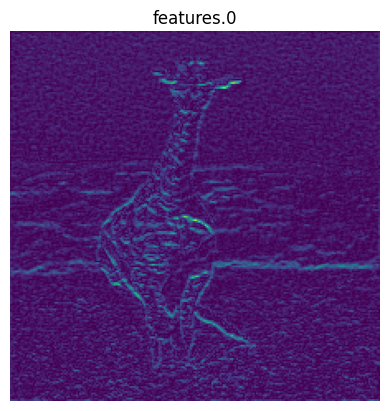

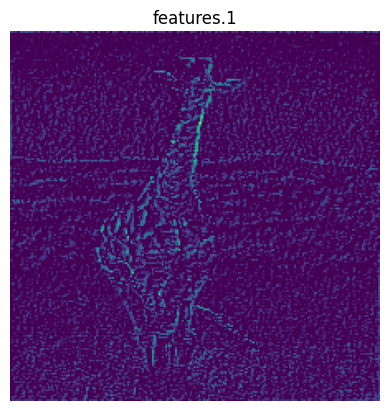

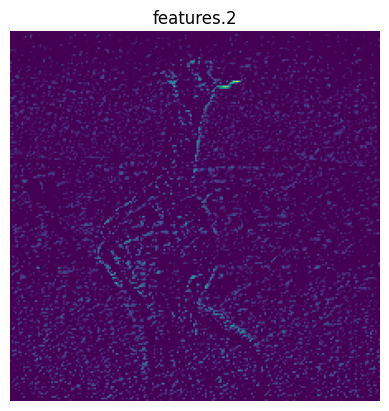

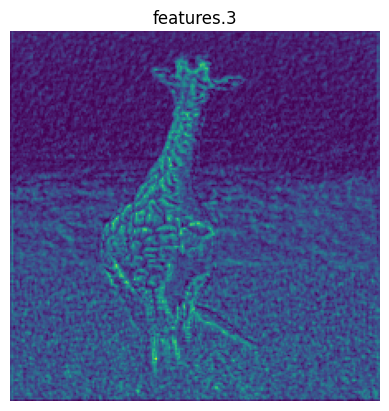

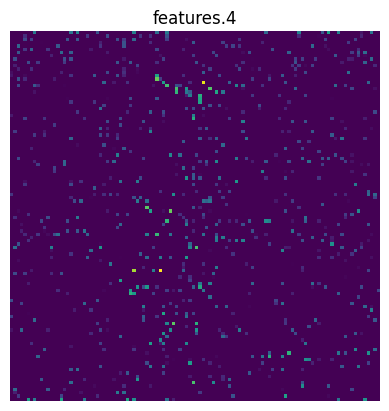

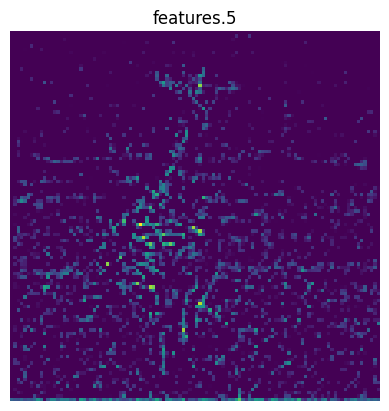

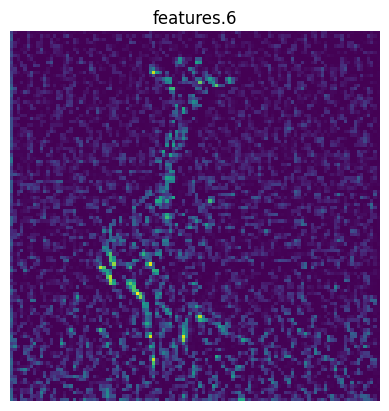

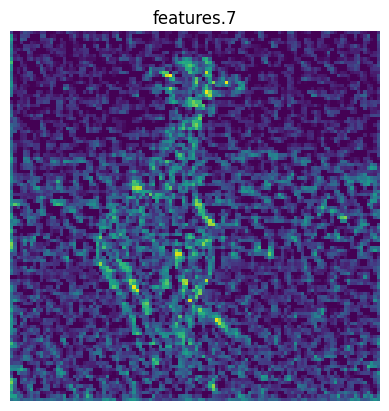

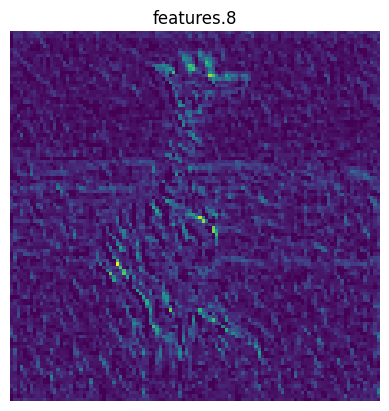

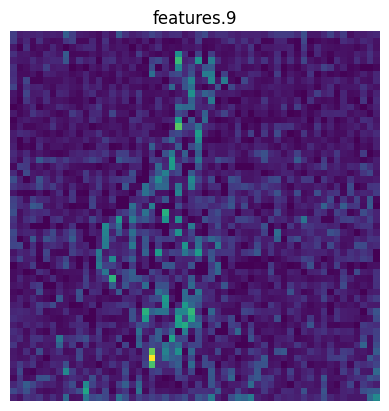

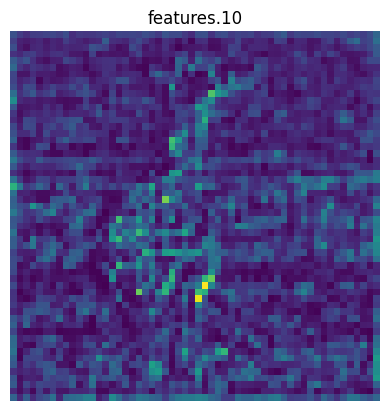

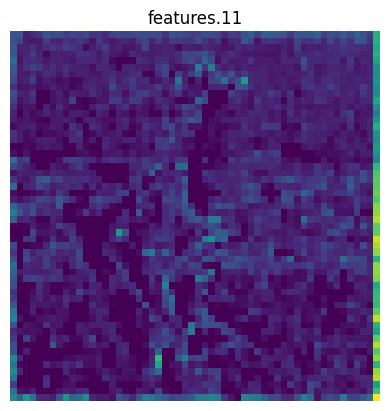

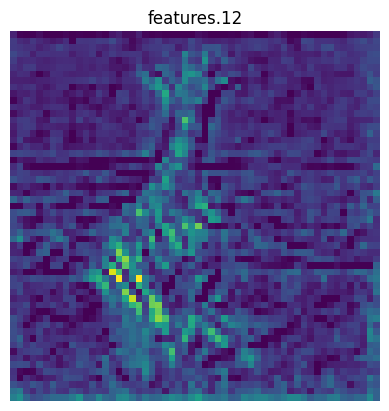

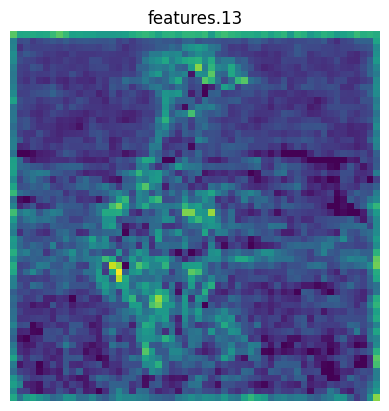

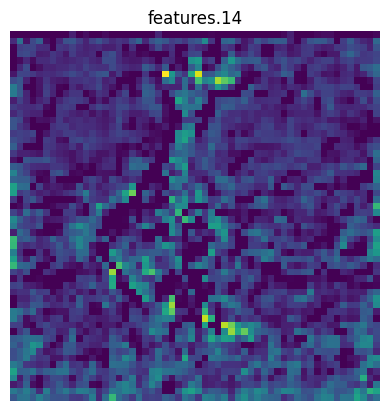

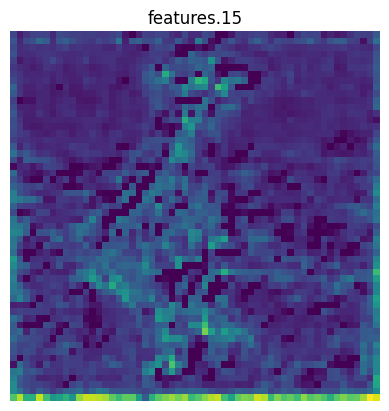

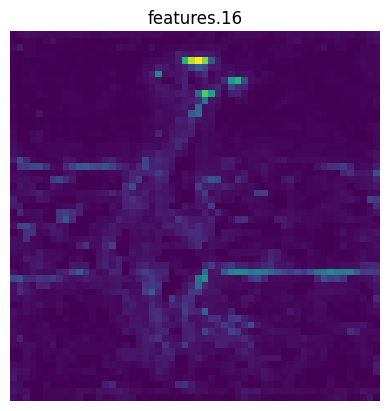

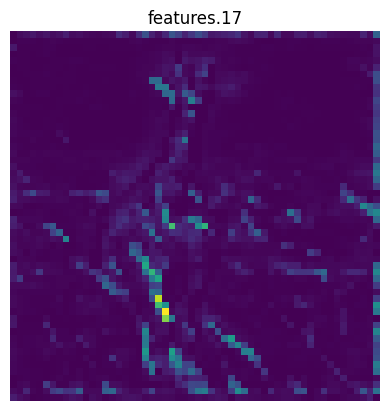

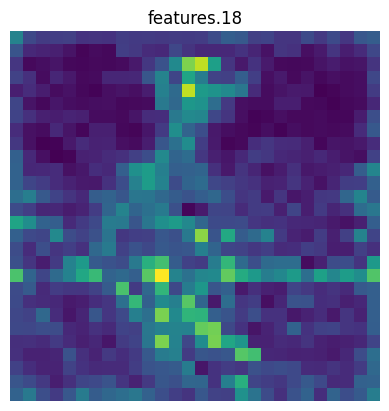

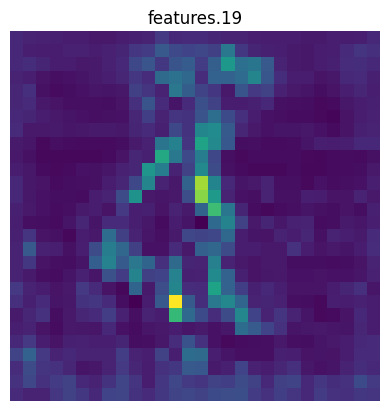

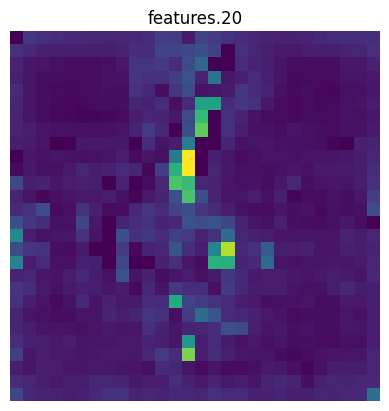

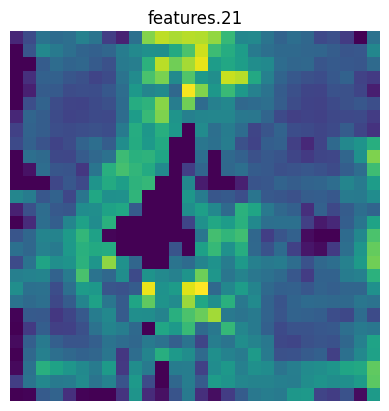

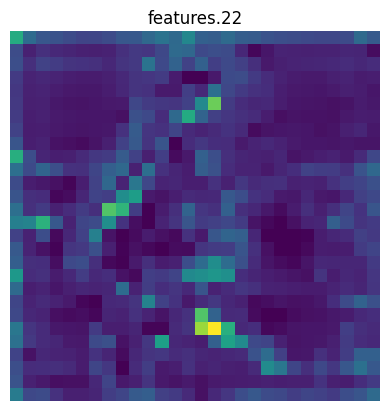

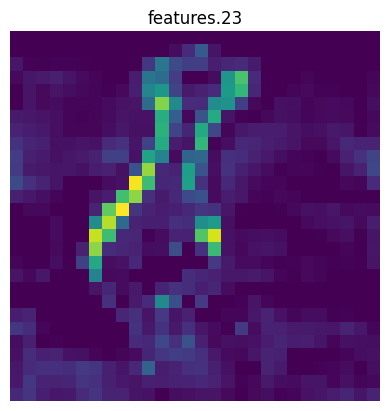

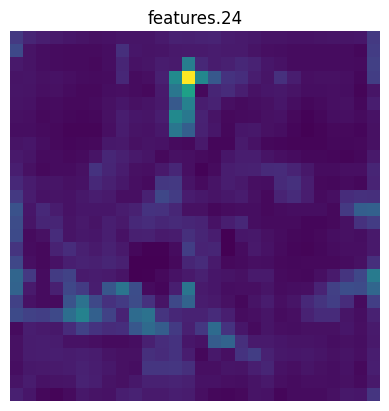

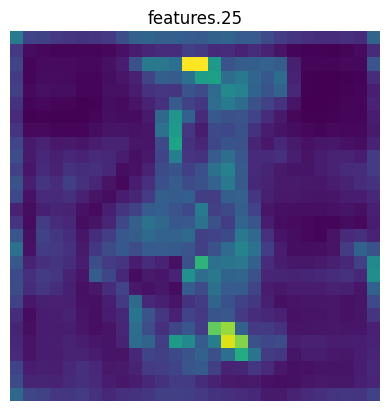

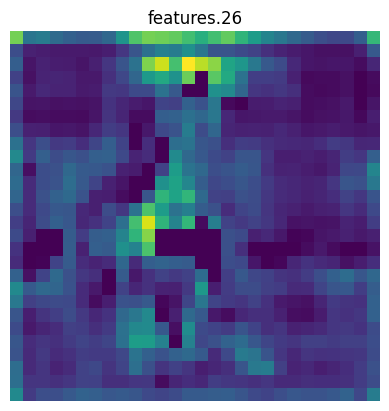

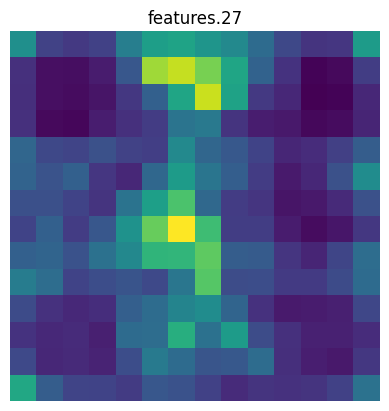

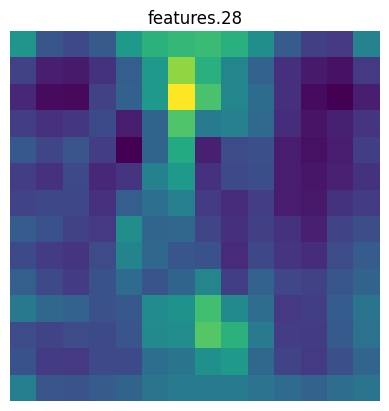

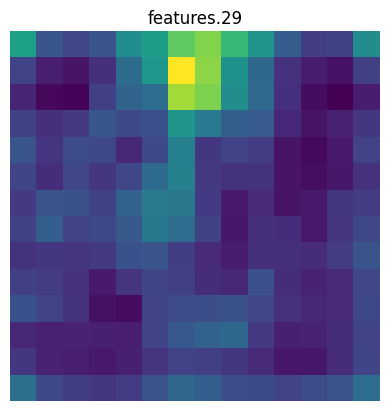

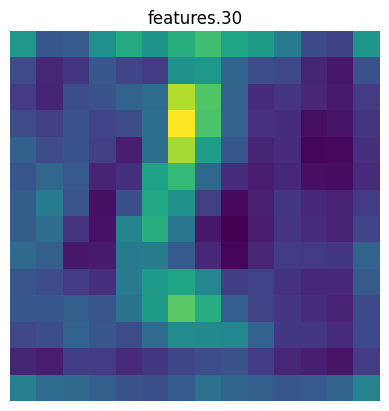

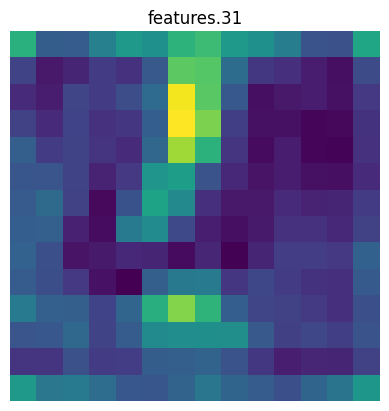

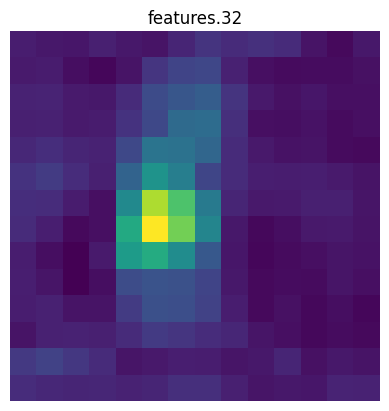

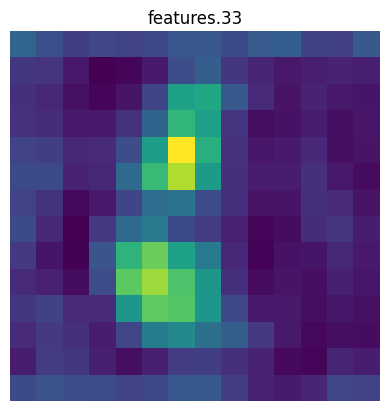

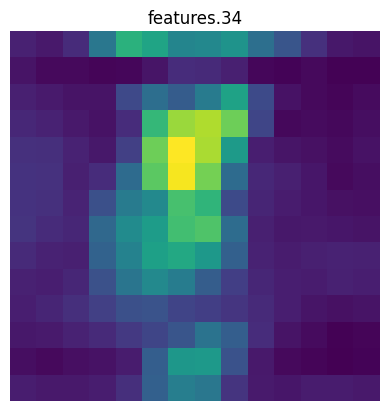

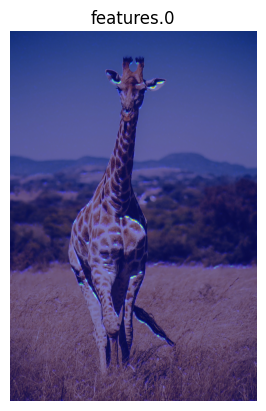

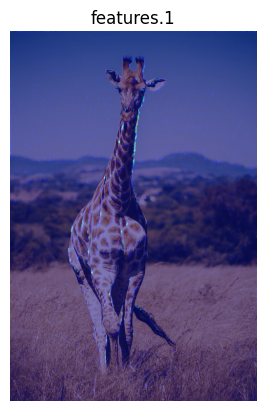

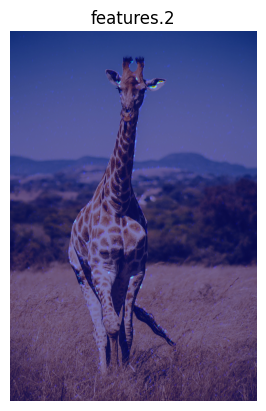

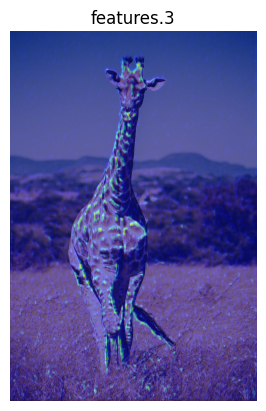

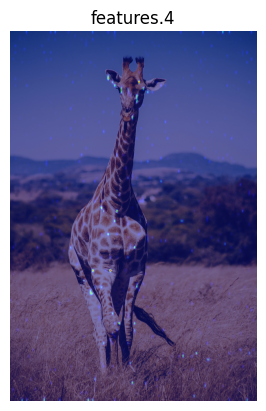

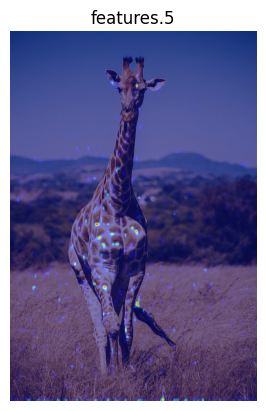

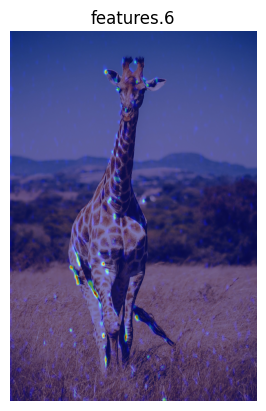

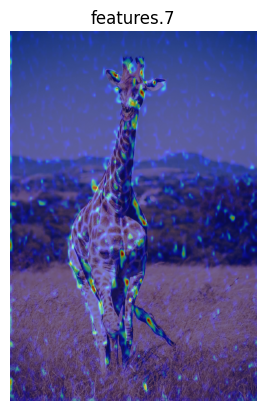

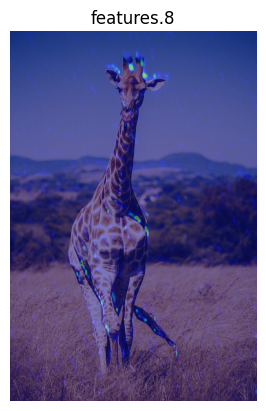

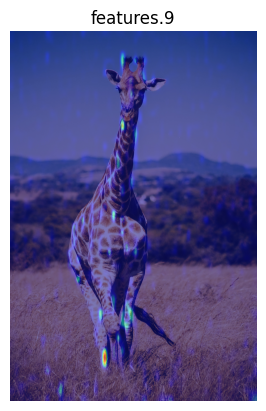

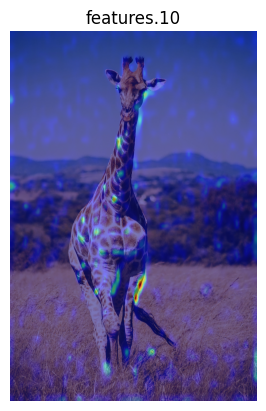

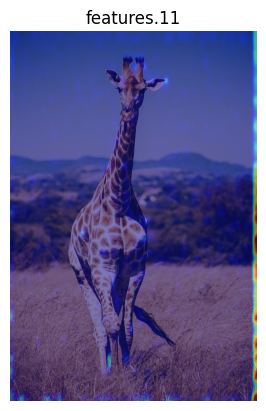

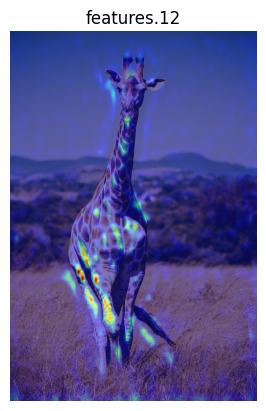

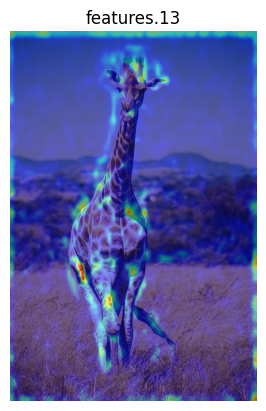

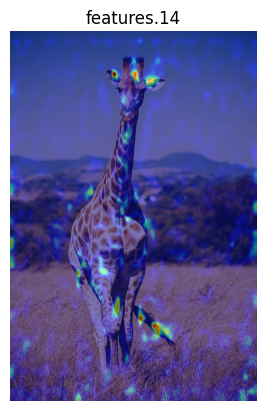

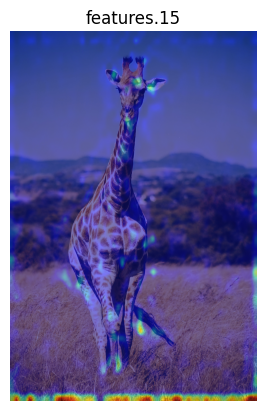

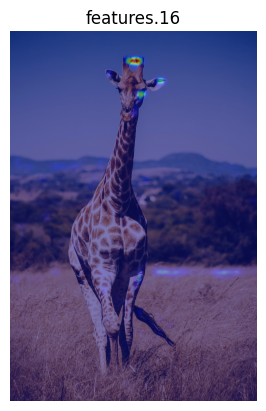

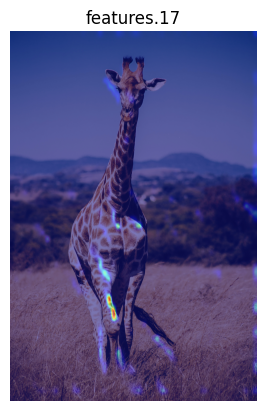

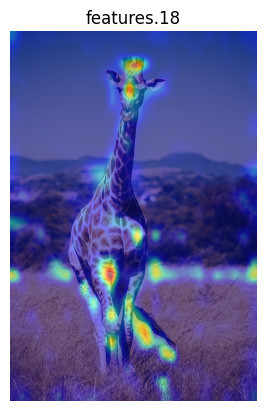

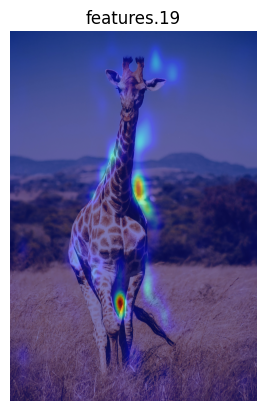

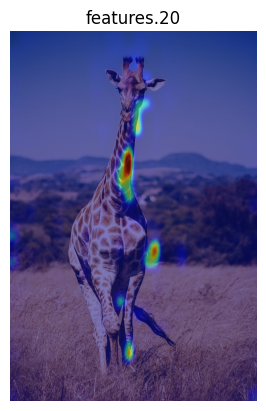

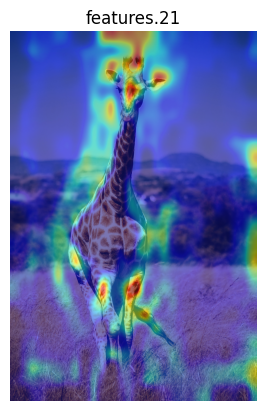

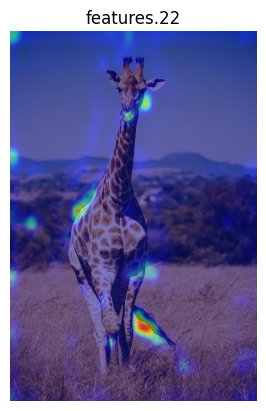

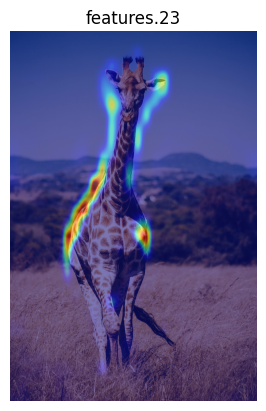

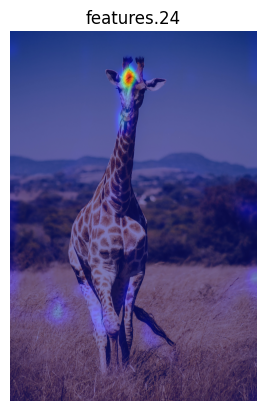

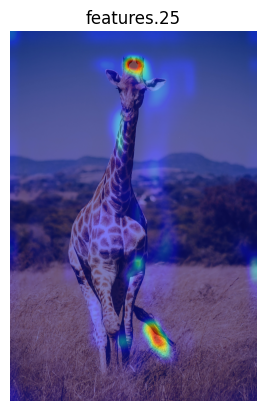

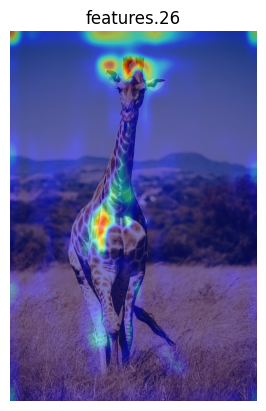

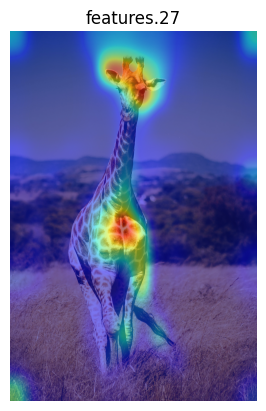

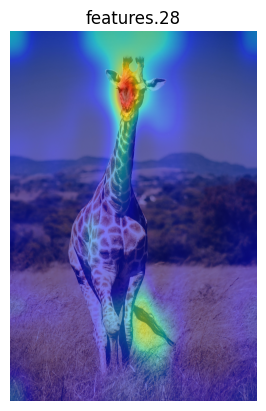

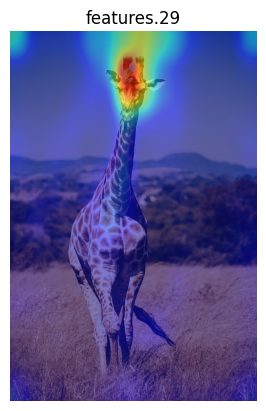

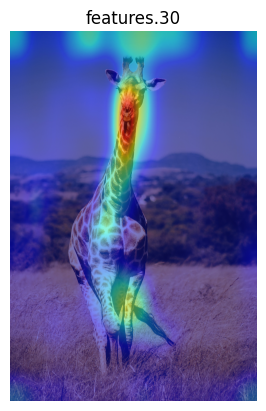

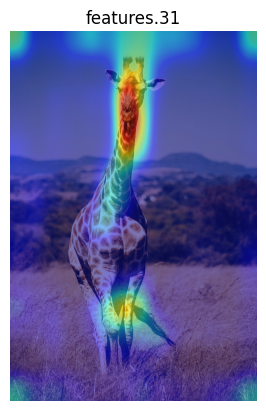

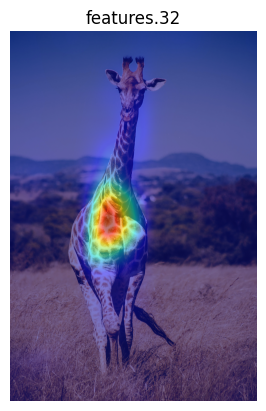

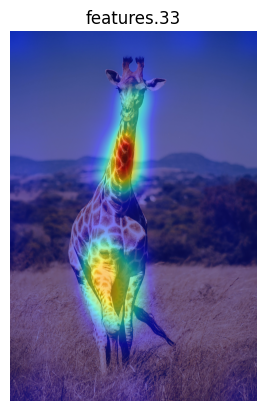

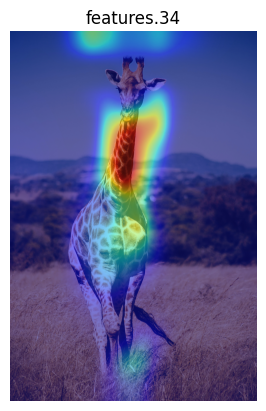

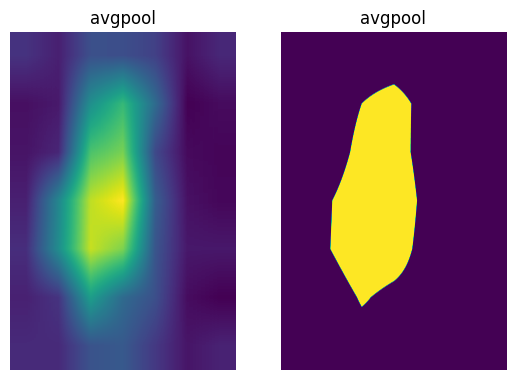

In [17]:
# Keep the features layers until the last CNN layer
features = []
features = [vgg19_model.features[x] for x in range(35)]

explainer.generate_explanation(img, input_tensor, target_layer=features)